In [1]:
import sys
import os

# Add the parent directory of "tests" to sys.path
sys.path.append(os.path.abspath("/Users/workspace/Software/Layered_Tank_Simulation/CherenkovSim/"))

In [ ]:
from cherenkov_sim.particle import Particle
from cherenkov_sim.muon import Muon
from cherenkov_sim.gamma import Gamma
from cherenkov_sim.material import Material
from cherenkov_sim.tracker import ParticleTracker, GammaTracker
from cherenkov_sim.constants import ALPHA, R_TANK, H_TANK, TOP_TANK

import numpy as np
from astropy import units as u
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
ice = Material(
    name = 'Ice',
    Z_A = 0.55509 * u.mol / u.g,
    rho = 0.9180 * u.g / u.cm**3,
    I = 79.7 * u.eV, 
    n = 1.309,
    X0 = 39.31 * u.cm, 
    delta_file = '/Users/workspace/Software/PHYS-F-420/lesson2/delta_elec.txt'
)

water = Material(
    name = 'water',
    Z_A = 0.55509 * u.mol / u.g,
    rho = 1 * u.g / u.cm**3,
    I = 79.7 * u.eV,
    n = 1.333,
    X0 = 36.08 * u.cm, 
    delta_file = '/Users/workspace/Software/PHYS-F-420/lesson2/delta_elec.txt'
)

In [4]:
# Define primary energy 
e = 0.1 * u.GeV

In [5]:
# Extract starting position randomly from a circle corresponding to the top of the tank
N_event = int(1e3) # Choose number of particles 

# Gen. surface radius 
R_gen = 180 * u.cm 
 
def rnd_tank_start(R_gen, N_event): 
    r = R_gen * np.sqrt(np.random.uniform(0,1,size=N_event))
    alpha = np.random.uniform(0,2*np.pi, size=N_event) 
    z_value = 140 
    x0 = r * np.cos(alpha)   
    y0 = r * np.sin(alpha)  
    z0 = np.full(N_event,z_value) * u.cm
    return x0, y0, z0   


def rnd_direction(N_event):
    phi = np.random.uniform(0,2*np.pi, size=N_event)

    theta_0 = 0 * u.deg 
    theta_1 = 30 * u.deg 
    cos_theta_squared = np.random.uniform(np.cos(theta_1.to(u.rad))**2,np.cos(theta_0.to(u.rad))**2, size=N_event)
    cos_theta = np.sqrt(cos_theta_squared)
    theta = np.arccos(cos_theta) 
    return theta * u.rad, phi * u.rad

In [6]:
# Track muons inside the tank, considering energy loss and Cherenkov produciton 

muon_theta, muon_phi = rnd_direction(N_event)
x0,y0,z0 = rnd_tank_start(R_gen, N_event)  

initial_position = np.array([x0[0].value,y0[0].value,z0[0].value]) * u.cm
theta = muon_theta[0]

In [7]:
# Create list to store photon position 

all_photons = []
all_photons_z = []
all_photons_r = []

In [8]:
for i_evt in range(0, N_event):

    # Define particle 
    gamma = Gamma(energy = e)

    # Create the Tracker

    initial_position = np.array([x0[i_evt].value,y0[i_evt].value,z0[i_evt].value]) * u.cm

    gamma_tracker = GammaTracker(gamma, water, step_size= - 1.0 * u.cm,
                      position=initial_position, 
                      zenith=muon_theta[i_evt], 
                      azimuth=muon_phi[i_evt],
                      is_verbose = False)
    
    print('Simulating gamma track #',i_evt)

    out = gamma_tracker.propagate()

    if(gamma_tracker.is_pair_production):
        electron_tracker = out[0] 
        positron_tracker = out[1]   

        electron_tracker.is_verbose = True

        electron_tracker.propagate(lambda1 = 300 * u.nm, lambda2 = 600 * u.nm)
        positron_tracker.propagate(lambda1 = 300 * u.nm, lambda2 = 600 * u.nm)

        all_photons_z.extend(electron_tracker.cherenkov_photons_z)
        all_photons_r.extend(electron_tracker.cherenkov_photons_r)
        all_photons_z.extend(positron_tracker.cherenkov_photons_z)
        all_photons_r.extend(positron_tracker.cherenkov_photons_r)


Simulating gamma track # 0
Starting particle tracking at position [ 108.86315662 -100.24817184   84.45251527] cm with energy 0.0500 GeV
Tracking complete. Particle stopped.
Simulating gamma track # 1
Starting particle tracking at position [132.28882088 -50.51919119 116.61335584] cm with energy 0.0500 GeV
Tracking complete. Particle stopped.
Simulating gamma track # 2
Starting particle tracking at position [133.73437084  21.03430409 113.93147659] cm with energy 0.0500 GeV
Tracking complete. Particle stopped.
Simulating gamma track # 3
Simulating gamma track # 4
Starting particle tracking at position [ 43.06798847 -94.35082378  78.52931748] cm with energy 0.0500 GeV
Tracking complete. Particle stopped.
Simulating gamma track # 5
Starting particle tracking at position [  18.32303483 -132.62783381  107.18721924] cm with energy 0.0500 GeV
Tracking complete. Particle stopped.
Simulating gamma track # 6
Starting particle tracking at position [-114.72481088   88.9725677    74.97159561] cm with

In [9]:
len(all_photons_z)

7897033

In [10]:
# Define range and bins of photon density histogram 

bin_width = 10
r_bins = np.arange(0,R_TANK.value+bin_width,bin_width)
z_bins = np.arange(0,H_TANK.value+bin_width,bin_width)

# Compute volume corresponding to each bin 
r_min, r_max = r_bins[:-1], r_bins[1:]
z_min, z_max = z_bins[:-1], z_bins[1:]

vol = np.zeros((len(r_min),len(z_min))) 
r_centers = (r_min+r_max) / 2.
z_centers = (z_min + z_max) / 2.

for i in range(len(r_min)): 
    for j in range(len(z_min)): 
        vol[i][j] = np.pi * (r_max[i]**2-r_min[i]**2)*(z_max[j]-z_min[j])
        
r_centers, z_centers = np.meshgrid(r_centers,z_centers)  

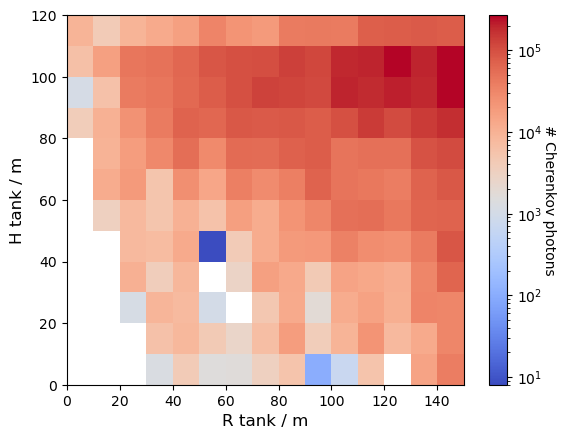

In [11]:
hist2d = plt.hist2d(all_photons_r, all_photons_z, bins=[r_bins,z_bins], norm=mpl.colors.LogNorm(), cmap = plt.cm.coolwarm )
#hist2d = plt.hist2d(r_photon, z_photon, bins=[r_bins,z_bins], norm=mpl.colors.LogNorm(vmin=np.min(hist2d[0])), cmap = plt.cm.coolwarm)
#hist2d = plt.hist2d(r_photon, z_photon, bins=[r_bins,z_bins], cmap = plt.cm.coolwarm)

plt.xlabel('R tank / m',size=12)
plt.ylabel('H tank / m',size=12)
cbar = plt.colorbar()
cbar.set_label('# Cherenkov photons', rotation=270, labelpad=10)

(12, 15)
(12, 15)


Text(0, 0.5, 'H tank / m')

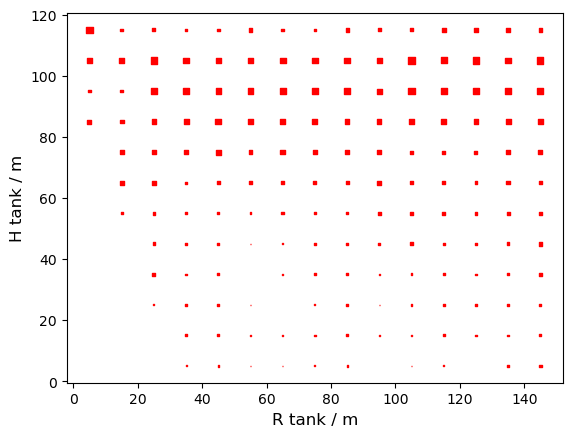

In [12]:
plt.figure(dpi=100)
bin_count = hist2d[0]
ph_density = bin_count / vol 

print(r_centers.shape)
print(z_centers.shape)

#plt.scatter(r_centers, z_centers, c = ph_density.T, marker='s')
#plt.colorbar()

plt.scatter(r_centers, z_centers, s=ph_density.T*7, marker='s', c='red')
plt.xlabel('R tank / m',size=12)
plt.ylabel('H tank / m',size=12)

(array([  67177.,  214419.,  370864.,  506806.,  646900.,  839715.,
         895092., 1248015., 1301920., 1806125.]),
 array([  0.81878305,  15.7670115 ,  30.71523995,  45.6634684 ,
         60.61169685,  75.5599253 ,  90.50815375, 105.45638219,
        120.40461064, 135.35283909, 150.30106754]),
 <BarContainer object of 10 artists>)

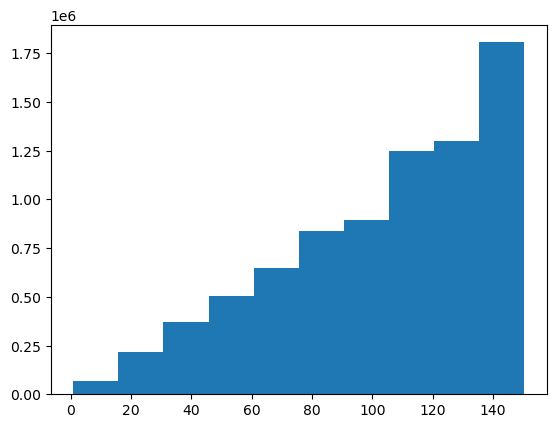

In [14]:
plt.hist(all_photons_r)

In [15]:
all_photons_z

[np.float64(83.21706666994305),
 np.float64(83.38408908889177),
 np.float64(82.60715808681766),
 np.float64(82.50434775660854),
 np.float64(82.72314008495611),
 np.float64(83.0939903219245),
 np.float64(82.64283417140666),
 np.float64(83.24498700021621),
 np.float64(82.53284451387007),
 np.float64(83.14322651208501),
 np.float64(83.09456717799758),
 np.float64(82.71508968470133),
 np.float64(83.31329420105308),
 np.float64(82.5520725302149),
 np.float64(82.98671020596636),
 np.float64(83.44562099924252),
 np.float64(83.24003411979196),
 np.float64(82.88059667942846),
 np.float64(82.66870237100797),
 np.float64(82.95547959158334),
 np.float64(82.73042230201806),
 np.float64(82.54311457204676),
 np.float64(83.3046999231249),
 np.float64(82.51723549594007),
 np.float64(82.4786471690577),
 np.float64(82.76673222498158),
 np.float64(83.09116217477501),
 np.float64(83.31283728780355),
 np.float64(82.62767999446828),
 np.float64(83.3583673440972),
 np.float64(83.02250515723082),
 np.float64(8

In [ ]:
mask = np.logical_and(all_photons_z > )